In [1]:
import xarray as xr
from mpl_toolkits.axes_grid1 import make_axes_locatable

# file = '/Users/mikesmith/Downloads/5MHz_6km_realtime-agg_2f30_fcd6_a21e.nc'
file = '/Users/mikesmith/Downloads/5MHz_6km_realtime-agg_a667_a2f2_f11b.nc'

ds = xr.open_dataset(file).mean('time')
ds

<xarray.Dataset>
Dimensions:      (latitude: 185, longitude: 155)
Coordinates:
  * latitude     (latitude) float32 33.55 33.6 33.66 33.71 ... 43.37 43.42 43.47
  * longitude    (longitude) float32 -76.98 -76.92 -76.86 ... -68.09 -68.03
Data variables:
    u            (latitude, longitude) float32 nan nan nan nan ... nan nan nan
    v            (latitude, longitude) float32 nan nan nan nan ... nan nan nan
    u_err        (latitude, longitude) float32 nan nan nan nan ... nan nan nan
    v_err        (latitude, longitude) float32 nan nan nan nan ... nan nan nan
    num_radials  (latitude, longitude) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    site_code    (latitude, longitude) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [2]:
tds = ds.coarsen(longitude=2, latitude=2, boundary='pad').mean()
tds

<xarray.Dataset>
Dimensions:      (latitude: 93, longitude: 78)
Coordinates:
  * latitude     (latitude) float32 33.58 33.68 33.79 33.9 ... 43.28 43.39 43.47
  * longitude    (longitude) float32 -76.95 -76.83 -76.72 ... -68.12 -68.03
Data variables:
    u            (latitude, longitude) float32 nan nan nan nan ... nan nan nan
    v            (latitude, longitude) float32 nan nan nan nan ... nan nan nan
    u_err        (latitude, longitude) float32 nan nan nan nan ... nan nan nan
    v_err        (latitude, longitude) float32 nan nan nan nan ... nan nan nan
    num_radials  (latitude, longitude) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    site_code    (latitude, longitude) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [3]:
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

projection = ccrs.Mercator()

lon = tds.longitude
lat = tds.latitude

extent = [
    lon.min() - 1,
    lon.max() + 1,
    lat.min() - 1,
    lat.max() + 1
]

LAND = cfeature.NaturalEarthFeature(
    'physical', 'land', '10m',
    edgecolor='face',
    facecolor='tan'
)

state_lines = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none'
)

#### Let's turn the mapping features into a function

In [4]:
def get_ticks(bounds, dirs, otherbounds):
    dirs = dirs.lower()
    l0 = np.float(bounds[0])
    l1 = np.float(bounds[1])
    r = np.max([l1 - l0, np.float(otherbounds[1]) - np.float(otherbounds[0])])
    if r <= 1.5:
        # <1.5 degrees: 15' major ticks, 5' minor ticks
        minor_int = 1.0 / 12.0
        major_int = 1.0 / 4.0
    elif r <= 3.0:
        # <3 degrees: 30' major ticks, 10' minor ticks
        minor_int = 1.0 / 6.0
        major_int = 0.5
    elif r <= 7.0:
        # <7 degrees: 1d major ticks, 15' minor ticks
        minor_int = 0.25
        major_int = np.float(1)
    elif r <= 15:
        # <15 degrees: 2d major ticks, 30' minor ticks
        minor_int = 0.5
        major_int = np.float(2)
    elif r <= 30:
        # <30 degrees: 3d major ticks, 1d minor ticks
        minor_int = np.float(1)
        major_int = np.float(3)
    else:
        # >=30 degrees: 5d major ticks, 1d minor ticks
        minor_int = np.float(1)
        major_int = np.float(5)

    minor_ticks = np.arange(np.ceil(l0 / minor_int) * minor_int, np.ceil(l1 / minor_int) * minor_int + minor_int,
                            minor_int)
    minor_ticks = minor_ticks[minor_ticks <= l1]
    major_ticks = np.arange(np.ceil(l0 / major_int) * major_int, np.ceil(l1 / major_int) * major_int + major_int,
                            major_int)
    major_ticks = major_ticks[major_ticks <= l1]

    if major_int < 1:
        d, m, s = dd2dms(np.array(major_ticks))
        if dirs == 'we' or dirs == 'ew' or dirs == 'lon' or dirs == 'long' or dirs == 'longitude':
            n = 'W' * sum(d < 0)
            p = 'E' * sum(d >= 0)
            dir = n + p
            major_tick_labels = [str(np.abs(int(d[i]))) + u"\N{DEGREE SIGN}" + str(int(m[i])) + "'" + dir[i] for i in
                                 range(len(d))]
        elif dirs == 'sn' or dirs == 'ns' or dirs == 'lat' or dirs == 'latitude':
            n = 'S' * sum(d < 0)
            p = 'N' * sum(d >= 0)
            dir = n + p
            major_tick_labels = [str(np.abs(int(d[i]))) + u"\N{DEGREE SIGN}" + str(int(m[i])) + "'" + dir[i] for i in
                                 range(len(d))]
        else:
            major_tick_labels = [str(int(d[i])) + u"\N{DEGREE SIGN}" + str(int(m[i])) + "'" for i in range(len(d))]
    else:
        d = major_ticks
        if dirs == 'we' or dirs == 'ew' or dirs == 'lon' or dirs == 'long' or dirs == 'longitude':
            n = 'W' * sum(d < 0)
            p = 'E' * sum(d >= 0)
            dir = n + p
            major_tick_labels = [str(np.abs(int(d[i]))) + u"\N{DEGREE SIGN}" + dir[i] for i in range(len(d))]
        elif dirs == 'sn' or dirs == 'ns' or dirs == 'lat' or dirs == 'latitude':
            n = 'S' * sum(d < 0)
            p = 'N' * sum(d >= 0)
            dir = n + p
            major_tick_labels = [str(np.abs(int(d[i]))) + u"\N{DEGREE SIGN}" + dir[i] for i in range(len(d))]
        else:
            major_tick_labels = [str(int(d[i])) + u"\N{DEGREE SIGN}" for i in range(len(d))]

    return minor_ticks, major_ticks, major_tick_labels

In [5]:
def add_map_features(ax, extent):
#     # Gridlines and grid labels
#     gl = ax.gridlines(
#         draw_labels=True,
#         linewidth=.5,
#         color='black',
#         alpha=0.25,
#         linestyle='--',
#     )

#     gl.xlabels_top = gl.ylabels_right = False
#     gl.xlabel_style = {'size': 16, 'color': 'black'}
#     gl.ylabel_style = {'size': 16, 'color': 'black'}

#     gl.xformatter = LONGITUDE_FORMATTER
#     gl.yformatter = LATITUDE_FORMATTER

    xl = [extent[0], extent[1]]
    yl = [extent[2], extent[3]]

    tick0x, tick1, ticklab = get_ticks(xl, 'we', yl)
    ax.set_xticks(tick0x, minor=True, crs=ccrs.PlateCarree())
    ax.set_xticks(tick1, crs=ccrs.PlateCarree())
    ax.set_xticklabels(ticklab, fontsize=14)

    # get and add latitude ticks/labels
    tick0y, tick1, ticklab = get_ticks(yl, 'sn', xl)
    ax.set_yticks(tick0y, minor=True, crs=ccrs.PlateCarree())
    ax.set_yticks(tick1, crs=ccrs.PlateCarree())
    ax.set_yticklabels(ticklab, fontsize=14)

    gl = ax.gridlines(draw_labels=False, linewidth=.5, color='gray', alpha=0.75, linestyle='--', crs=ccrs.PlateCarree())
    gl.xlocator = mticker.FixedLocator(tick0x)
    gl.ylocator = mticker.FixedLocator(tick0y)

    ax.tick_params(which='major',
                   direction='out',
                   bottom=True, top=True,
                   labelbottom=True, labeltop=False,
                   left=True, right=True,
                   labelleft=True, labelright=False,
                   length=5, width=2)

    ax.tick_params(which='minor',
                   direction='out',
                   bottom=True, top=True,
                   labelbottom=True, labeltop=False,
                   left=True, right=True,
                   labelleft=True, labelright=False,
                   width=1)

    # Axes properties and features
    ax.set_extent(extent)
    ax.add_feature(LAND, zorder=0, edgecolor='black')
    ax.add_feature(cfeature.LAKES)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(state_lines, edgecolor='black')
    return ax

### Let's change the arrows

In [6]:
# velocity_min = np.int32(np.nanmin(speed)) # Get the minimum speed from the data
# velocity_max =np.int32(np.nanmax(speed)) # Get the maximum speed from the data

# velocity_min = 0 # Get the minimum speed from the data
# velocity_max = 40 # Get the maximum speed from the data

# Setup a keyword argument, kwargs, dictionary to pass optional arguments to the quiver plot
kwargs = dict(
    transform=ccrs.PlateCarree(),
    scale=65, # Number of data units per arrow length unit, e.g., m/s per plot width; a smaller scale parameter makes the arrow longer. Default is None.
    headwidth=2.75, # Head width as multiple of shaft width.
    headlength=2.75, #Head length as multiple of shaft width.
    headaxislength=2.5, # Head length at shaft intersection.
    minshaft=1,
    minlength=1
)

# Clip the colors 
# color_clipped = np.clip(speed, velocity_min, velocity_max).squeeze(),

# Set the colorbar ticks to correspond to the velocity minimum and maximum of the data with a step of 20... Append the max velocity 
# ticks = np.append(np.arange(velocity_min, velocity_max, 5), velocity_max)

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

lon, lat = np.meshgrid(tds.longitude, tds.latitude)
u = tds.u.data
v = tds.v.data

# 
# resample onto a 50x50 grid
nx, ny = 50, 50

# (N, 2) arrays of input x,y coords and u,v values
pts = np.vstack((lon.ravel(), lat.ravel())).T
vals = np.vstack((u.ravel(), v.ravel())).T

# the new x and y coordinates for the grid, which will correspond to the
# columns and rows of u and v respectively
xi = np.linspace(lon.min(), lon.max(), nx)
yi = np.linspace(lat.min(), lat.max(), ny)

# an (nx * ny, 2) array of x,y coordinates to interpolate at
ipts = np.vstack(a.ravel() for a in np.meshgrid(yi, xi)[::-1]).T

# an (nx * ny, 2) array of interpolated u, v values
ivals = griddata(pts, vals, ipts, method='linear') # Only works with nearest

# reshape interpolated u,v values into (ny, nx) arrays
ui, vi = ivals.T
ui.shape = vi.shape = (ny, nx)

/Users/mikesmith/miniconda3/envs/hfradar/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


In [8]:
np.nanmax(yi)

43.47378158569336

/Users/mikesmith/miniconda3/envs/hfradar/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/mikesmith/miniconda3/envs/hfradar/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.

<GeoAxesSubplot:>

/Users/mikesmith/miniconda3/envs/hfradar/lib/python3.7/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mikesmith/miniconda3/envs/hfradar/lib/python3.7/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mikesmith/miniconda3/envs/hfradar/lib/python3.7/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/Users/mikesmith/mi

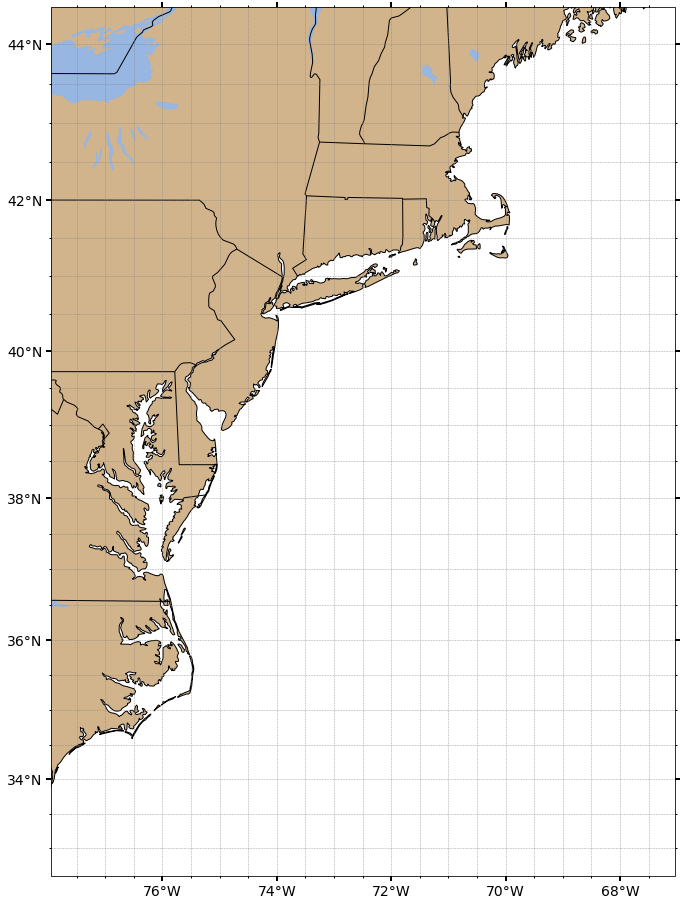

In [9]:
# Initialize blank plot with a mercator projection
fig, ax = plt.subplots(
    figsize=(22, 16),
    subplot_kw=dict(projection=ccrs.Mercator())
)

norm = np.sqrt(ui**2 + vi**2)
norm_flat = norm.flatten()

start_points = np.array([xi.flatten(), yi.flatten()]).T
scale = .2/np.nanmax(norm)

for i in range(start_points.shape[0]):
    plt.streamplot(xi, yi, ui, vi, 
                   color='k',
                   start_points=np.array([start_points[i,:]]),
                   minlength=.95*norm_flat[i]*scale,
                   maxlength=1.0*norm_flat[i]*scale,
                   integration_direction='backward', 
                   density=10, 
                   arrowsize=0.0,
                   transform=ccrs.PlateCarree()
                  )

# Add map features to the axes
add_map_features(ax, extent)

# plt.quiver(xi, yi, ui/norm, vi/norm, scale=30, transform=ccrs.PlateCarree())

/Users/mikesmith/miniconda3/envs/hfradar/lib/python3.7/site-packages/matplotlib/patches.py:3027: RuntimeWarning: invalid value encountered in double_scalars
  cos_t, sin_t = head_length / head_dist, head_width / head_dist


(-3.0, 3.0, -3.0, 3.0)

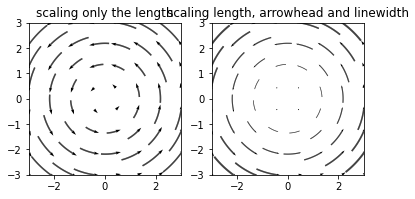

In [10]:
import matplotlib.pyplot as plt
import numpy as np
w = 3
Y, X = np.mgrid[-w:w:8j, -w:w:8j]

U = -Y
V = X
norm = np.sqrt(U**2 + V**2)
norm_flat = norm.flatten()

start_points = np.array([X.flatten(),Y.flatten()]).T

plt.clf()
scale = .2/np.max(norm)

plt.subplot(121)
plt.title('scaling only the length')
for i in range(start_points.shape[0]):
    plt.streamplot(X,Y,U,V, color='k', start_points=np.array([start_points[i,:]]),minlength=.95*norm_flat[i]*scale, maxlength=1.0*norm_flat[i]*scale,
                integration_direction='backward', density=10, arrowsize=0.0)
plt.quiver(X,Y,U/norm, V/norm,scale=30)
plt.axis('square')



plt.subplot(122)
plt.title('scaling length, arrowhead and linewidth')
for i in range(start_points.shape[0]):
    plt.streamplot(X,Y,U,V, color='k', start_points=np.array([start_points[i,:]]),minlength=.95*norm_flat[i]*scale, maxlength=1.0*norm_flat[i]*scale,
                integration_direction='backward', density=10, arrowsize=0.0, linewidth=.5*norm_flat[i])
plt.quiver(X,Y,U/np.max(norm), V/np.max(norm),scale=30)

plt.axis('square')

In [11]:
"""
Streamline plotting for 2D vector fields.
"""
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import six
from six.moves import xrange
from scipy.interpolate import interp1d

import numpy as np
import matplotlib
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.collections as mcollections
import matplotlib.lines as mlines
import matplotlib.patches as patches


def velovect(axes, x, y, u, v, linewidth=None, color=None,
               cmap=None, norm=None, arrowsize=1, arrowstyle='-|>',
               transform=None, zorder=None, start_points=None,
               scale=1.0, grains=15):
    """Draws streamlines of a vector flow.
    *x*, *y* : 1d arrays
        an *evenly spaced* grid.
    *u*, *v* : 2d arrays
        x and y-velocities. Number of rows should match length of y, and
        the number of columns should match x.
    *density* : float or 2-tuple
        Controls the closeness of streamlines. When `density = 1`, the domain
        is divided into a 30x30 grid---*density* linearly scales this grid.
        Each cell in the grid can have, at most, one traversing streamline.
        For different densities in each direction, use [density_x, density_y].
    *linewidth* : numeric or 2d array
        vary linewidth when given a 2d array with the same shape as velocities.
    *color* : matplotlib color code, or 2d array
        Streamline color. When given an array with the same shape as
        velocities, *color* values are converted to colors using *cmap*.
    *cmap* : :class:`~matplotlib.colors.Colormap`
        Colormap used to plot streamlines and arrows. Only necessary when using
        an array input for *color*.
    *norm* : :class:`~matplotlib.colors.Normalize`
        Normalize object used to scale luminance data to 0, 1. If None, stretch
        (min, max) to (0, 1). Only necessary when *color* is an array.
    *arrowsize* : float
        Factor scale arrow size.
    *arrowstyle* : str
        Arrow style specification.
        See :class:`~matplotlib.patches.FancyArrowPatch`.
    *minlength* : float
        Minimum length of streamline in axes coordinates.
    *start_points*: Nx2 array
        Coordinates of starting points for the streamlines.
        In data coordinates, the same as the ``x`` and ``y`` arrays.
    *zorder* : int
        any number
    *scale* : float
        Maximum length of streamline in axes coordinates.
    Returns:
        *stream_container* : StreamplotSet
            Container object with attributes
                - lines: `matplotlib.collections.LineCollection` of streamlines
                - arrows: collection of `matplotlib.patches.FancyArrowPatch`
                  objects representing arrows half-way along stream
                  lines.
            This container will probably change in the future to allow changes
            to the colormap, alpha, etc. for both lines and arrows, but these
            changes should be backward compatible.
    """
    grid = Grid(x, y)
    mask = StreamMask(10)
    dmap = DomainMap(grid, mask)

    if zorder is None:
        zorder = mlines.Line2D.zorder

    # default to data coordinates
    if transform is None:
        transform = axes.transData

    if color is None:
        color = axes._get_lines.get_next_color()

    if linewidth is None:
        linewidth = matplotlib.rcParams['lines.linewidth']

    line_kw = {}
    arrow_kw = dict(arrowstyle=arrowstyle, mutation_scale=10 * arrowsize)

    use_multicolor_lines = isinstance(color, np.ndarray)
    if use_multicolor_lines:
        if color.shape != grid.shape:
            raise ValueError(
                "If 'color' is given, must have the shape of 'Grid(x,y)'")
        line_colors = []
        color = np.ma.masked_invalid(color)
    else:
        line_kw['color'] = color
        arrow_kw['color'] = color

    if isinstance(linewidth, np.ndarray):
        if linewidth.shape != grid.shape:
            raise ValueError(
                "If 'linewidth' is given, must have the shape of 'Grid(x,y)'")
        line_kw['linewidth'] = []
    else:
        line_kw['linewidth'] = linewidth
        arrow_kw['linewidth'] = linewidth

    line_kw['zorder'] = zorder
    arrow_kw['zorder'] = zorder

    ## Sanity checks.
    if u.shape != grid.shape or v.shape != grid.shape:
        raise ValueError("'u' and 'v' must be of shape 'Grid(x,y)'")

    u = np.ma.masked_invalid(u)
    v = np.ma.masked_invalid(v)
    magnitude = np.sqrt(u**2 + v**2)
    magnitude/=np.max(magnitude)

    resolution = scale/grains
    minlength = .9*resolution
    integrate = get_integrator(u, v, dmap, minlength, resolution, magnitude)

    trajectories = []
    edges = []
    
    if start_points is None:
        start_points=_gen_starting_points(x,y,grains)
    
    sp2 = np.asanyarray(start_points, dtype=float).copy()

    # Check if start_points are outside the data boundaries
    for xs, ys in sp2:
        if not (grid.x_origin <= xs <= grid.x_origin + grid.width
                and grid.y_origin <= ys <= grid.y_origin + grid.height):
            raise ValueError("Starting point ({}, {}) outside of data "
                             "boundaries".format(xs, ys))

    # Convert start_points from data to array coords
    # Shift the seed points from the bottom left of the data so that
    # data2grid works properly.
    sp2[:, 0] -= grid.x_origin
    sp2[:, 1] -= grid.y_origin

    for xs, ys in sp2:
        xg, yg = dmap.data2grid(xs, ys)
        t = integrate(xg, yg)
        if t is not None:
            trajectories.append(t[0])
            edges.append(t[1])

    if use_multicolor_lines:
        if norm is None:
            norm = mcolors.Normalize(color.min(), color.max())
        if cmap is None:
            cmap = cm.get_cmap(matplotlib.rcParams['image.cmap'])
        else:
            cmap = cm.get_cmap(cmap)

    streamlines = []
    arrows = []
    for t, edge in zip(trajectories,edges):
        tgx = np.array(t[0])
        tgy = np.array(t[1])
        
        # Rescale from grid-coordinates to data-coordinates.
        tx, ty = dmap.grid2data(*np.array(t))
        tx += grid.x_origin
        ty += grid.y_origin

        
        points = np.transpose([tx, ty]).reshape(-1, 1, 2)
        streamlines.extend(np.hstack([points[:-1], points[1:]]))

        # Add arrows half way along each trajectory.
        s = np.cumsum(np.sqrt(np.diff(tx) ** 2 + np.diff(ty) ** 2))
        n = np.searchsorted(s, s[-1])
        arrow_tail = (tx[n], ty[n])
        arrow_head = (np.mean(tx[n:n + 2]), np.mean(ty[n:n + 2]))

        if isinstance(linewidth, np.ndarray):
            line_widths = interpgrid(linewidth, tgx, tgy)[:-1]
            line_kw['linewidth'].extend(line_widths)
            arrow_kw['linewidth'] = line_widths[n]

        if use_multicolor_lines:
            color_values = interpgrid(color, tgx, tgy)[:-1]
            line_colors.append(color_values)
            arrow_kw['color'] = cmap(norm(color_values[n]))
        
        if not edge:
            p = patches.FancyArrowPatch(
                arrow_tail, arrow_head, transform=transform, **arrow_kw)
        else:
            continue
        
        ds = np.sqrt((arrow_tail[0]-arrow_head[0])**2+(arrow_tail[1]-arrow_head[1])**2)
        
        if ds<1e-15: continue #remove vanishingly short arrows that cause Patch to fail
        
        axes.add_patch(p)
        arrows.append(p)  

    lc = mcollections.LineCollection(
        streamlines, transform=transform, **line_kw)
    lc.sticky_edges.x[:] = [grid.x_origin, grid.x_origin + grid.width]
    lc.sticky_edges.y[:] = [grid.y_origin, grid.y_origin + grid.height]
    if use_multicolor_lines:
        lc.set_array(np.ma.hstack(line_colors))
        lc.set_cmap(cmap)
        lc.set_norm(norm)
    axes.add_collection(lc)
    axes.autoscale_view()

    ac = matplotlib.collections.PatchCollection(arrows)
    stream_container = StreamplotSet(lc, ac)
    return stream_container

class StreamplotSet(object):

    def __init__(self, lines, arrows, **kwargs):
        self.lines = lines
        self.arrows = arrows


# Coordinate definitions
# ========================

class DomainMap(object):
    """Map representing different coordinate systems.
    Coordinate definitions:
    * axes-coordinates goes from 0 to 1 in the domain.
    * data-coordinates are specified by the input x-y coordinates.
    * grid-coordinates goes from 0 to N and 0 to M for an N x M grid,
      where N and M match the shape of the input data.
    * mask-coordinates goes from 0 to N and 0 to M for an N x M mask,
      where N and M are user-specified to control the density of streamlines.
    This class also has methods for adding trajectories to the StreamMask.
    Before adding a trajectory, run `start_trajectory` to keep track of regions
    crossed by a given trajectory. Later, if you decide the trajectory is bad
    (e.g., if the trajectory is very short) just call `undo_trajectory`.
    """

    def __init__(self, grid, mask):
        self.grid = grid
        self.mask = mask
        # Constants for conversion between grid- and mask-coordinates
        self.x_grid2mask = (mask.nx - 1) / grid.nx
        self.y_grid2mask = (mask.ny - 1) / grid.ny

        self.x_mask2grid = 1. / self.x_grid2mask
        self.y_mask2grid = 1. / self.y_grid2mask

        self.x_data2grid = 1. / grid.dx
        self.y_data2grid = 1. / grid.dy

    def grid2mask(self, xi, yi):
        """Return nearest space in mask-coords from given grid-coords."""
        return (int((xi * self.x_grid2mask) + 0.5),
                int((yi * self.y_grid2mask) + 0.5))

    def mask2grid(self, xm, ym):
        return xm * self.x_mask2grid, ym * self.y_mask2grid

    def data2grid(self, xd, yd):
        return xd * self.x_data2grid, yd * self.y_data2grid

    def grid2data(self, xg, yg):
        return xg / self.x_data2grid, yg / self.y_data2grid

    def start_trajectory(self, xg, yg):
        xm, ym = self.grid2mask(xg, yg)
        self.mask._start_trajectory(xm, ym)

    def reset_start_point(self, xg, yg):
        xm, ym = self.grid2mask(xg, yg)
        self.mask._current_xy = (xm, ym)

    def update_trajectory(self, xg, yg):
        
        xm, ym = self.grid2mask(xg, yg)
        #self.mask._update_trajectory(xm, ym)

    def undo_trajectory(self):
        self.mask._undo_trajectory()
        


class Grid(object):
    """Grid of data."""
    def __init__(self, x, y):

        if x.ndim == 1:
            pass
        elif x.ndim == 2:
            x_row = x[0, :]
            if not np.allclose(x_row, x):
                raise ValueError("The rows of 'x' must be equal")
            x = x_row
        else:
            raise ValueError("'x' can have at maximum 2 dimensions")

        if y.ndim == 1:
            pass
        elif y.ndim == 2:
            y_col = y[:, 0]
            if not np.allclose(y_col, y.T):
                raise ValueError("The columns of 'y' must be equal")
            y = y_col
        else:
            raise ValueError("'y' can have at maximum 2 dimensions")

        self.nx = len(x)
        self.ny = len(y)

        self.dx = x[1] - x[0]
        self.dy = y[1] - y[0]

        self.x_origin = x[0]
        self.y_origin = y[0]

        self.width = x[-1] - x[0]
        self.height = y[-1] - y[0]

    @property
    def shape(self):
        return self.ny, self.nx

    def within_grid(self, xi, yi):
        """Return True if point is a valid index of grid."""
        # Note that xi/yi can be floats; so, for example, we can't simply check
        # `xi < self.nx` since `xi` can be `self.nx - 1 < xi < self.nx`
        return xi >= 0 and xi <= self.nx - 1 and yi >= 0 and yi <= self.ny - 1


class StreamMask(object):
    """Mask to keep track of discrete regions crossed by streamlines.
    The resolution of this grid determines the approximate spacing between
    trajectories. Streamlines are only allowed to pass through zeroed cells:
    When a streamline enters a cell, that cell is set to 1, and no new
    streamlines are allowed to enter.
    """

    def __init__(self, density):
        if np.isscalar(density):
            if density <= 0:
                raise ValueError("If a scalar, 'density' must be positive")
            self.nx = self.ny = int(30 * density)
        else:
            if len(density) != 2:
                raise ValueError("'density' can have at maximum 2 dimensions")
            self.nx = int(30 * density[0])
            self.ny = int(30 * density[1])
        self._mask = np.zeros((self.ny, self.nx))
        self.shape = self._mask.shape

        self._current_xy = None

    def __getitem__(self, *args):
        return self._mask.__getitem__(*args)

    def _start_trajectory(self, xm, ym):
        """Start recording streamline trajectory"""
        self._traj = []
        self._update_trajectory(xm, ym)

    def _undo_trajectory(self):
        """Remove current trajectory from mask"""
        for t in self._traj:
            self._mask.__setitem__(t, 0)

    def _update_trajectory(self, xm, ym):
        """Update current trajectory position in mask.
        If the new position has already been filled, raise `InvalidIndexError`.
        """
        #if self._current_xy != (xm, ym):
        #    if self[ym, xm] == 0:
        self._traj.append((ym, xm))
        self._mask[ym, xm] = 1
        self._current_xy = (xm, ym)
        #    else:
        #        raise InvalidIndexError




# Integrator definitions
#========================

def get_integrator(u, v, dmap, minlength, resolution, magnitude):

    # rescale velocity onto grid-coordinates for integrations.
    u, v = dmap.data2grid(u, v)

    # speed (path length) will be in axes-coordinates
    u_ax = u / dmap.grid.nx
    v_ax = v / dmap.grid.ny
    speed = np.ma.sqrt(u_ax ** 2 + v_ax ** 2)

    def forward_time(xi, yi):
        ds_dt = interpgrid(speed, xi, yi)
        if ds_dt == 0:
            raise TerminateTrajectory()
        dt_ds = 1. / ds_dt
        ui = interpgrid(u, xi, yi)
        vi = interpgrid(v, xi, yi)
        return ui * dt_ds, vi * dt_ds


    def integrate(x0, y0):
        """Return x, y grid-coordinates of trajectory based on starting point.
        Integrate both forward and backward in time from starting point in
        grid coordinates.
        Integration is terminated when a trajectory reaches a domain boundary
        or when it crosses into an already occupied cell in the StreamMask. The
        resulting trajectory is None if it is shorter than `minlength`.
        """

        stotal, x_traj, y_traj = 0., [], []

        
        dmap.start_trajectory(x0, y0)

        dmap.reset_start_point(x0, y0)
        stotal, x_traj, y_traj, m_total, hit_edge = _integrate_rk12(x0, y0, dmap, forward_time, resolution, magnitude)

        
        if len(x_traj)>1:
            return (x_traj, y_traj), hit_edge
        else:  # reject short trajectories
            dmap.undo_trajectory()
            return None

    return integrate


def _integrate_rk12(x0, y0, dmap, f, resolution, magnitude):
    """2nd-order Runge-Kutta algorithm with adaptive step size.
    This method is also referred to as the improved Euler's method, or Heun's
    method. This method is favored over higher-order methods because:
    1. To get decent looking trajectories and to sample every mask cell
       on the trajectory we need a small timestep, so a lower order
       solver doesn't hurt us unless the data is *very* high resolution.
       In fact, for cases where the user inputs
       data smaller or of similar grid size to the mask grid, the higher
       order corrections are negligible because of the very fast linear
       interpolation used in `interpgrid`.
    2. For high resolution input data (i.e. beyond the mask
       resolution), we must reduce the timestep. Therefore, an adaptive
       timestep is more suited to the problem as this would be very hard
       to judge automatically otherwise.
    This integrator is about 1.5 - 2x as fast as both the RK4 and RK45
    solvers in most setups on my machine. I would recommend removing the
    other two to keep things simple.
    """
    # This error is below that needed to match the RK4 integrator. It
    # is set for visual reasons -- too low and corners start
    # appearing ugly and jagged. Can be tuned.
    maxerror = 0.003

    # This limit is important (for all integrators) to avoid the
    # trajectory skipping some mask cells. We could relax this
    # condition if we use the code which is commented out below to
    # increment the location gradually. However, due to the efficient
    # nature of the interpolation, this doesn't boost speed by much
    # for quite a bit of complexity.
    maxds = min(1. / dmap.mask.nx, 1. / dmap.mask.ny, 0.1)

    ds = maxds
    stotal = 0
    xi = x0
    yi = y0
    xf_traj = []
    yf_traj = []
    m_total = []
    hit_edge = False
    
    while dmap.grid.within_grid(xi, yi):
        xf_traj.append(xi)
        yf_traj.append(yi)
        m_total.append(interpgrid(magnitude, xi, yi))
        try:
            k1x, k1y = f(xi, yi)
            k2x, k2y = f(xi + ds * k1x,
                         yi + ds * k1y)
        except IndexError:
            # Out of the domain on one of the intermediate integration steps.
            # Take an Euler step to the boundary to improve neatness.
            ds, xf_traj, yf_traj = _euler_step(xf_traj, yf_traj, dmap, f)
            stotal += ds
            hit_edge = True
            break
        except TerminateTrajectory:
            break

        dx1 = ds * k1x
        dy1 = ds * k1y
        dx2 = ds * 0.5 * (k1x + k2x)
        dy2 = ds * 0.5 * (k1y + k2y)

        nx, ny = dmap.grid.shape
        # Error is normalized to the axes coordinates
        error = np.sqrt(((dx2 - dx1) / nx) ** 2 + ((dy2 - dy1) / ny) ** 2)

        # Only save step if within error tolerance
        if error < maxerror:
            xi += dx2
            yi += dy2
            
            dmap.update_trajectory(xi, yi)
            
            if not dmap.grid.within_grid(xi, yi):
                hit_edge=True
            
            if (stotal + ds) > resolution*np.mean(m_total):
                break
            stotal += ds

        # recalculate stepsize based on step error
        if error == 0:
            ds = maxds
        else:
            ds = min(maxds, 0.85 * ds * (maxerror / error) ** 0.5)

    return stotal, xf_traj, yf_traj, m_total, hit_edge


def _euler_step(xf_traj, yf_traj, dmap, f):
    """Simple Euler integration step that extends streamline to boundary."""
    ny, nx = dmap.grid.shape
    xi = xf_traj[-1]
    yi = yf_traj[-1]
    cx, cy = f(xi, yi)
    if cx == 0:
        dsx = np.inf
    elif cx < 0:
        dsx = xi / -cx
    else:
        dsx = (nx - 1 - xi) / cx
    if cy == 0:
        dsy = np.inf
    elif cy < 0:
        dsy = yi / -cy
    else:
        dsy = (ny - 1 - yi) / cy
    ds = min(dsx, dsy)
    xf_traj.append(xi + cx * ds)
    yf_traj.append(yi + cy * ds)
    return ds, xf_traj, yf_traj


# Utility functions
# ========================

def interpgrid(a, xi, yi):
    """Fast 2D, linear interpolation on an integer grid"""

    Ny, Nx = np.shape(a)
    if isinstance(xi, np.ndarray):
        x = xi.astype(int)
        y = yi.astype(int)
        # Check that xn, yn don't exceed max index
        xn = np.clip(x + 1, 0, Nx - 1)
        yn = np.clip(y + 1, 0, Ny - 1)
    else:
        x = int(xi)
        y = int(yi)
        # conditional is faster than clipping for integers
        if x == (Nx - 2):
            xn = x
        else:
            xn = x + 1
        if y == (Ny - 2):
            yn = y
        else:
            yn = y + 1

    a00 = a[y, x]
    a01 = a[y, xn]
    a10 = a[yn, x]
    a11 = a[yn, xn]
    xt = xi - x
    yt = yi - y
    a0 = a00 * (1 - xt) + a01 * xt
    a1 = a10 * (1 - xt) + a11 * xt
    ai = a0 * (1 - yt) + a1 * yt

    if not isinstance(xi, np.ndarray):
        if np.ma.is_masked(ai):
            raise TerminateTrajectory

    return ai


def _gen_starting_points(x,y,grains):
    
    eps = np.finfo(np.float32).eps
    
    tmp_x =  np.linspace(x.min()+eps, x.max()-eps, grains)
    tmp_y =  np.linspace(y.min()+eps, y.max()-eps, grains)
    
    xs = np.tile(tmp_x, grains)
    ys = np.repeat(tmp_y, grains)

    seed_points = np.array([list(xs), list(ys)])
    
    return seed_points.T

NameError: name 'TerminateTrajectory' is not defined

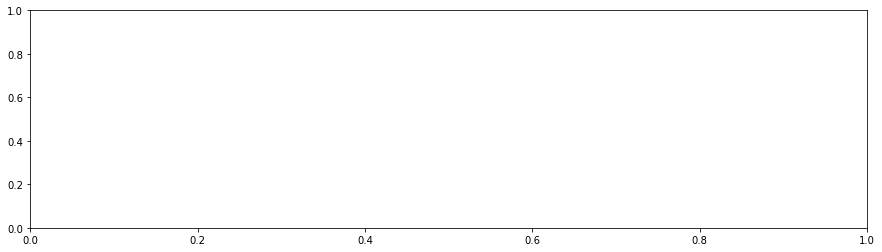

In [12]:
f, ax = plt.subplots(figsize=(15,4))


grains = 15
tmp =  np.linspace(-3, 3, grains)
xs = np.tile(tmp, grains)
ys = np.repeat(tmp, grains)

seed_points = np.array([list(xs), list(ys)])

scale=2.

velovect(ax, xi, yi, ui, vi, arrowstyle='fancy', scale = 1.5, grains = 15, color='k')


# cs = ax.contourf(xi,yi, W, cmap=plt.cm.viridis, alpha=0.5, zorder=-1)


# ax1.set_title("Quiver")
# ax2.set_title("Streamplot")
# ax3.set_title("Curved quivers")


# plt.colorbar(cs, ax=[ax1,ax2,ax3])    
plt.show()